In [170]:
import pandas as pd
import stumpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.patches import Rectangle
import datetime as dt
from functools import reduce
import time

In [171]:
#loading data
executed = pd.read_excel("P:\\Boyan Davidov\\QuantResearch\\TickDataBHM.xlsx", sheet_name="Executed")
executed = executed.set_index('Dates')

In [172]:
executed.head()

,Price_of_Execution,Executed_Size
Dates,,
2020-05-05 10:05:29,4.25,50000
2020-05-05 10:06:37,4.28,1000
2020-05-05 10:14:31,4.25,5000
2020-05-05 10:14:31,4.25,10000
2020-05-05 10:14:31,4.25,5000


In [173]:
#bid
bid = pd.read_excel("P:\\Boyan Davidov\\QuantResearch\\TickDataBHM.xlsx", sheet_name="Bid")
bid = bid.set_index('Dates')
#offer
offer = pd.read_excel("P:\\Boyan Davidov\\QuantResearch\\TickDataBHM.xlsx", sheet_name="Offer")
offer = offer.set_index('Dates')
#volume
volume = pd.read_excel("P:\\Boyan Davidov\\QuantResearch\\TickDataBHM.xlsx", sheet_name="Volume")
volume = volume.set_index('Dates')

This is not one-to-one data, there could be bid but not ask data for certain time. To allow easier anaylsis we group by time, sum all executed sizes and average bids/asks in case of different values for same timestamp

In [174]:
##### Grouping by time, averaging price and summing sizes

execc = (executed.groupby(executed.index)
       .agg({'Executed_Size':'sum', 'Price_of_Execution':'mean'}))

bid_m = (bid.groupby(bid.index)
       .agg({'Size_at_Bid':'sum', 'Bid':'mean'}))

offer_m = (offer.groupby(offer.index)
       .agg({'Size_at_Ask':'sum', 'Ask':'mean'}))

For instance, at timestamp 05/05/2020 10:28:44 when the second block was executed we see:

In [175]:
execc[execc.index == '05/05/2020  10:28:44']

,Executed_Size,Price_of_Execution
Dates,,
2020-05-05 10:28:44,28353,4.2


As next step we group the all parts of data (executed,bid,ask) matching on timestamp

In [176]:
##### Grouping by time, averaging price and summing sizes
data_frames = [execc, bid_m, offer_m]

df_merged_agg = reduce(lambda left,right: pd.merge(left,right,on=['Dates'],
                                            how='outer'), data_frames)

df_merged_agg.head()

,Executed_Size,Price_of_Execution,Size_at_Bid,Bid,Size_at_Ask,Ask
Dates,,,,,,
2020-05-05 10:05:29,50000.0,4.25,NaN,NaN,20000.0,4.29
2020-05-05 10:06:37,1000.0,4.28,10000.0,4.220000,9000.0,4.28
2020-05-05 10:14:31,20000.0,4.25,NaN,NaN,115000.0,4.25
2020-05-05 10:14:53,10000.0,4.25,NaN,NaN,25000.0,4.25
2020-05-05 10:15:23,96413.0,4.23,160084.0,4.226667,13545.0,4.23


To match with the volume data we need to modify the timestamps since volume arrivals are in format HH:MM without seconds. For example:

In [177]:
volume.index[1]

Timestamp('2020-05-05 10:06:00')

So let's add a new column to the bid/ask data on which we can merge with the volume (having same format)

In [178]:
#modify timestap of bid/ask data to match that of volume
def time(rows):
    return (pd.Timestamp(rows.year, rows.month,
                         rows.day, rows.hour, rows.minute))

#time(df_merged.index[1]) == volume.index[1]
df_merged_agg['volume_time'] = df_merged_agg.index.to_series().apply(time)

The new column is called volume_time

In [179]:
df_merged_agg.head()

,Executed_Size,Price_of_Execution,Size_at_Bid,Bid,Size_at_Ask,Ask,volume_time
Dates,,,,,,,
2020-05-05 10:05:29,50000.0,4.25,NaN,NaN,20000.0,4.29,2020-05-05 10:05:00
2020-05-05 10:06:37,1000.0,4.28,10000.0,4.220000,9000.0,4.28,2020-05-05 10:06:00
2020-05-05 10:14:31,20000.0,4.25,NaN,NaN,115000.0,4.25,2020-05-05 10:14:00
2020-05-05 10:14:53,10000.0,4.25,NaN,NaN,25000.0,4.25,2020-05-05 10:14:00
2020-05-05 10:15:23,96413.0,4.23,160084.0,4.226667,13545.0,4.23,2020-05-05 10:15:00


In [180]:
volume.head()

,Volume,Cumulative Volume
Dates,,
2020-05-05 10:05:00,50000,NaN
2020-05-05 10:06:00,1000,51000.0
2020-05-05 10:14:00,30000,81000.0
2020-05-05 10:15:00,96413,177413.0
2020-05-05 10:16:00,30042,207455.0


Now merge to get all data matched in one frame

In [229]:
merged = pd.merge(df_merged_agg, volume, right_index=True, left_on='volume_time')

In [228]:
merged.head()

,Executed_Size,Price_of_Execution,Size_at_Bid,Bid,Size_at_Ask,Ask,volume_time,Volume,Cumulative Volume
Dates,,,,,,,,,
2020-05-05 10:05:29,50000.0,4.25,NaN,NaN,20000.0,4.29,2020-05-05 10:05:00,50000,NaN
2020-05-05 10:05:51,NaN,NaN,1000.0,4.28,NaN,NaN,2020-05-05 10:05:00,50000,NaN
2020-05-05 10:06:37,1000.0,4.28,10000.0,4.22,9000.0,4.28,2020-05-05 10:06:00,1000,51000.0
2020-05-05 10:06:45,NaN,NaN,20000.0,4.18,NaN,NaN,2020-05-05 10:06:00,1000,51000.0
2020-05-05 10:14:31,20000.0,4.25,NaN,NaN,115000.0,4.25,2020-05-05 10:14:00,30000,81000.0


We don't need columns where no execution occured (i.e. NaN data). 

In [227]:
merged_clean = merged.dropna(subset=['Executed_Size'])

Creating a new column to monitor for bid/ask spread 

In [226]:
%%capture
merged_clean['Spread'] = merged_clean['Ask'] - merged_clean['Bid']

This is how our final dataframe looks:

In [225]:
merged_clean.head()

,Executed_Size,Price_of_Execution,Size_at_Bid,Bid,Size_at_Ask,Ask,volume_time,Volume,Cumulative Volume,Spread
Dates,,,,,,,,,,
2020-05-05 10:05:29,50000.0,4.25,NaN,NaN,20000.0,4.29,2020-05-05 10:05:00,50000,NaN,NaN
2020-05-05 10:06:37,1000.0,4.28,10000.0,4.220000,9000.0,4.28,2020-05-05 10:06:00,1000,51000.0,0.060000
2020-05-05 10:14:31,20000.0,4.25,NaN,NaN,115000.0,4.25,2020-05-05 10:14:00,30000,81000.0,NaN
2020-05-05 10:14:53,10000.0,4.25,NaN,NaN,25000.0,4.25,2020-05-05 10:14:00,30000,81000.0,NaN
2020-05-05 10:15:23,96413.0,4.23,160084.0,4.226667,13545.0,4.23,2020-05-05 10:15:00,96413,177413.0,0.003333


Now that we have matched and cleaned data - let's analyse. Our aim is to spot approximately repeated subsequences. Firstly we check whether there is any relationship between time and executed size (to assess whether twap algo could be useful). 

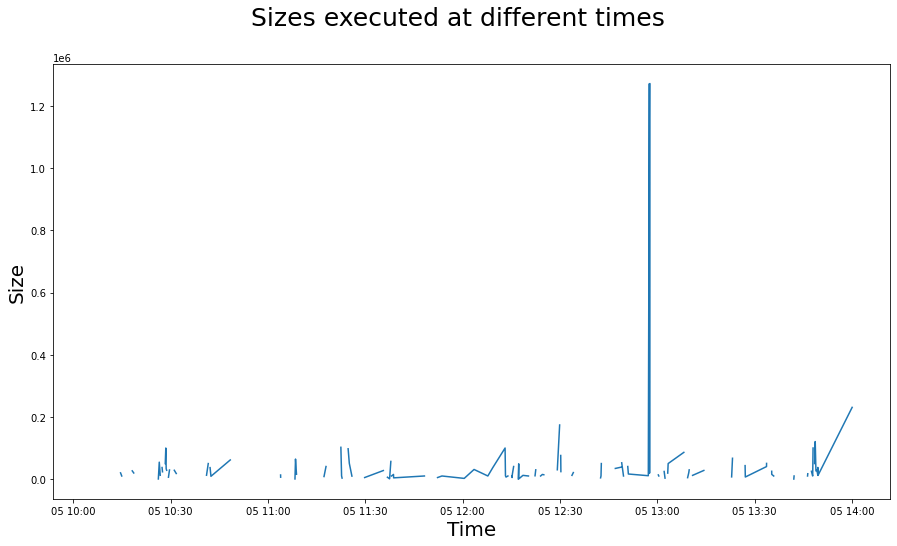

In [224]:
#search for motif based on time
plt.rcParams['figure.figsize'] = [15, 8]
plt.suptitle('Sizes executed at different times', fontsize='25')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Size', fontsize='20')
plt.plot(merged.index, merged['Executed_Size'].values)
plt.show()

There is no particular relationship from the plot. There is a spilke when the afternoon auction starts and one particular at 13:00 o’clock. But nothing significant to conclude from. 

Next, we check if any correlation between bid/ask spread and executed sizes:

(0.0, 0.08)

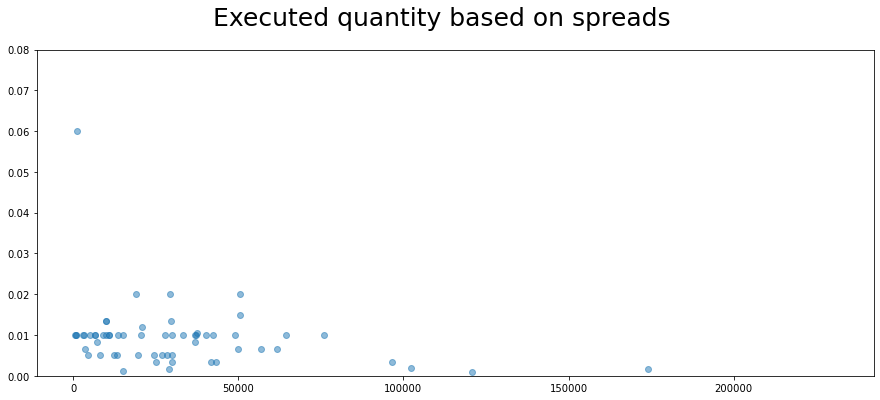

In [223]:
#search for motif based on bid/ask spread
plt.rcParams['figure.figsize'] = [15, 6]
plt.suptitle('Executed quantity based on spreads', fontsize='25')
plt.scatter(merged_clean['Executed_Size'], merged_clean['Spread'], alpha=0.5)
plt.ylim(0, 0.08)

We can see from the plot that most of the executed trades occured when spread was 0.01

(0.0, 300000.0)

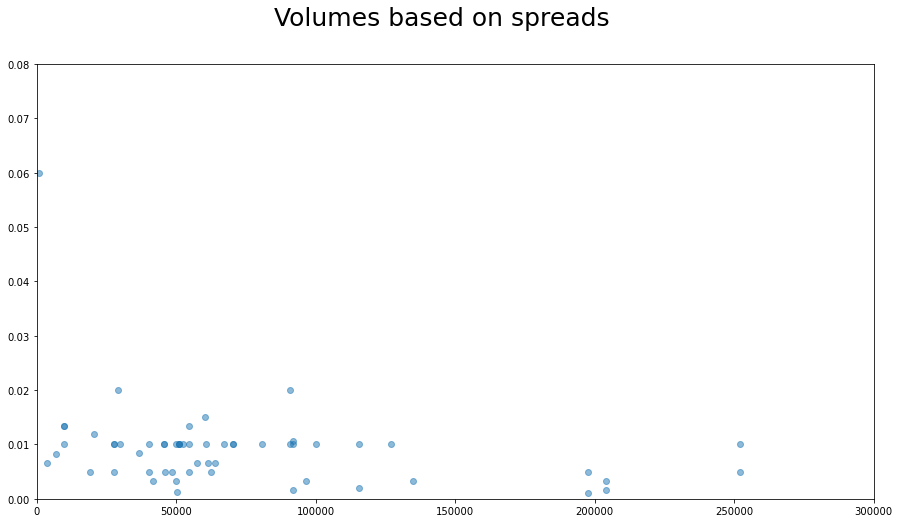

In [222]:
#volume
plt.suptitle('Volumes based on spreads', fontsize='25')
plt.scatter(merged_clean['Volume'], merged_clean['Spread'], alpha=0.5)
plt.ylim(0, 0.08)
plt.xlim(0, 300000)

(0.0, 300000.0)

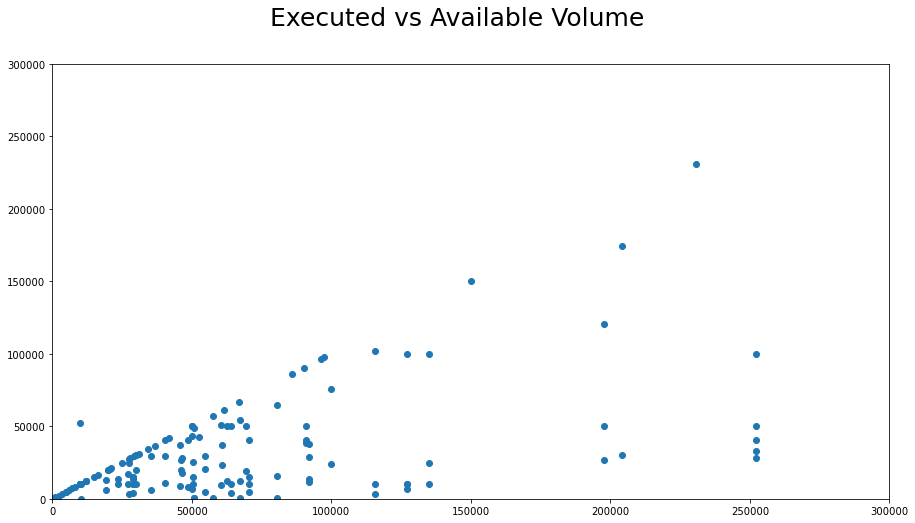

In [221]:
#search for motif based on volume
plt.suptitle('Executed vs Available Volume', fontsize='25')
plt.scatter(merged_clean['Volume'], merged_clean['Executed_Size'])
plt.ylim(0, 300000)
plt.xlim(0,300000)

These plots give some idea about the data and the relationships but to find some real motif we can try using stumpy package analyzing windows with sizes equal to the time between the blocks occured

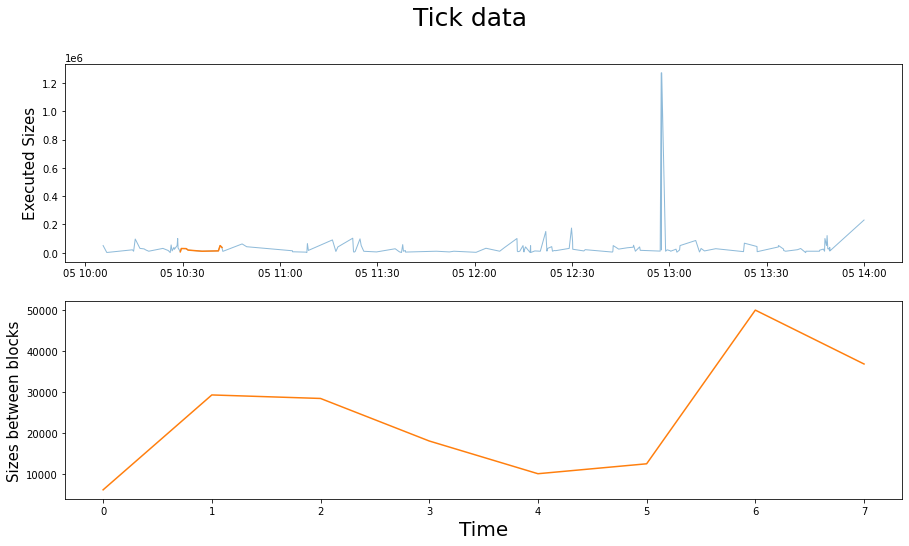

In [220]:
m = 8
fig, axs = plt.subplots(2)
plt.suptitle('Tick data', fontsize='25')
axs[0].set_ylabel("Executed Sizes", fontsize='15')
axs[0].plot(merged_clean['Executed_Size'], alpha=0.5, linewidth=1)
axs[0].plot(merged_clean['Executed_Size'].iloc[21:21+m])
rect = Rectangle((21, 0), m, 20000000, facecolor='blue')
#axs[0].add_patch(rect)
axs[1].set_xlabel("Time", fontsize='20')
axs[1].set_ylabel("Sizes between blocks", fontsize='15')
axs[1].plot(merged_clean['Executed_Size'].values[21:21+m], color='C1')
plt.show()

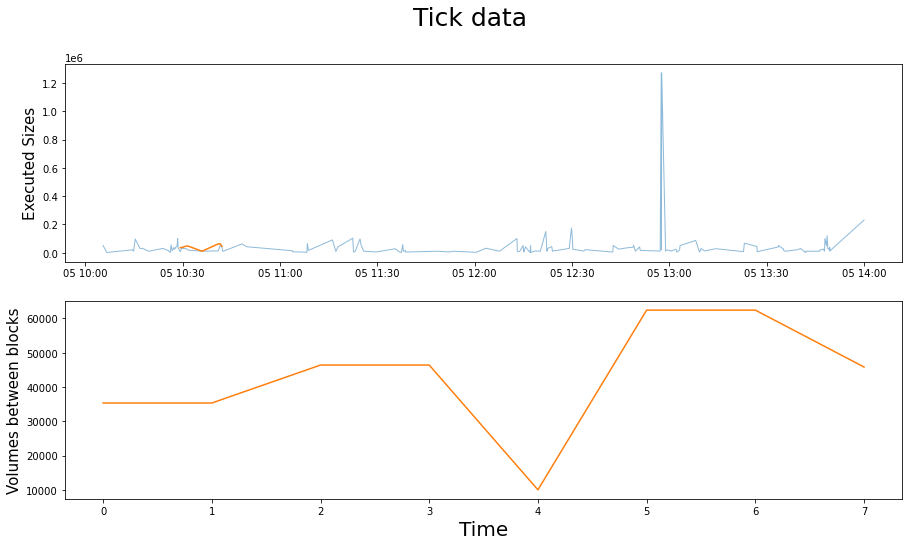

In [219]:
m = 8
fig, axs = plt.subplots(2)
plt.suptitle('Tick data', fontsize='25')
axs[0].set_ylabel("Executed Sizes", fontsize='15')
axs[0].plot(merged_clean['Executed_Size'], alpha=0.5, linewidth=1)
axs[0].plot(merged_clean['Volume'].iloc[21:21+m])
rect = Rectangle((21, 0), m, 20000000, facecolor='blue')
#axs[0].add_patch(rect)
axs[1].set_xlabel("Time", fontsize='20')
axs[1].set_ylabel("Volumes between blocks", fontsize='15')
axs[1].plot(merged_clean['Volume'].values[21:21+m], color='C1')
plt.show()

Clearly, this is VWAP algo. 

We can try using stumpy package to detect patterns (stumpy is comparing pairwise z-normalized Euclidean distances in time series). Firstly, we check via executed volume

In [218]:
#finding motif via stumpy package
m = 8
mp = stumpy.stump(merged_clean['Executed_Size'], m)


motif_idx = np.argsort(mp[:, 0])[0]
print(f"The motif is located at index {motif_idx}")


nearest_neighbor_idx = mp[motif_idx, 1]
print(f"The nearest neighbor is located at index {nearest_neighbor_idx}")

The motif is located at index 79
The nearest neighbor is located at index 95


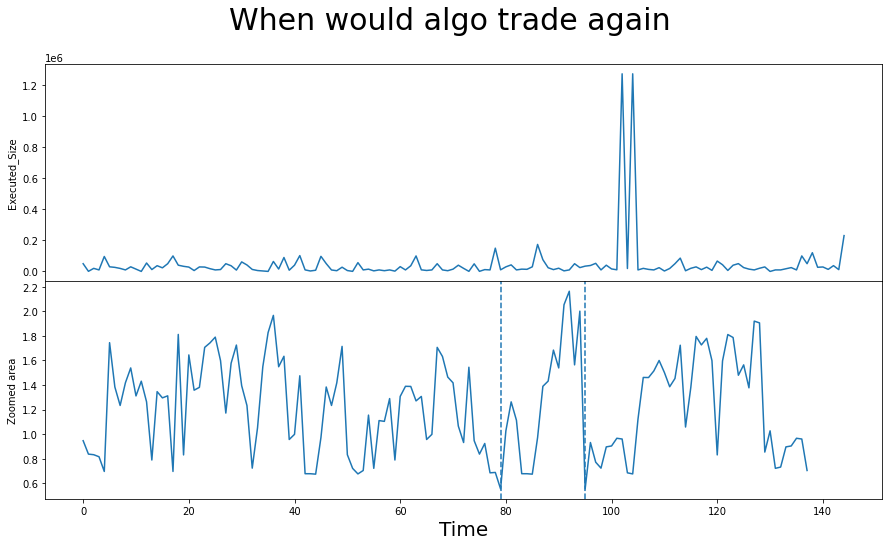

In [193]:
plt.rcParams['figure.figsize'] = [15, 8]
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('When would algo trade again', fontsize='30')
axs[0].plot(merged_clean['Executed_Size'].values)
axs[0].set_ylabel('Executed_Size', fontsize='10')
rect = Rectangle((motif_idx, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((nearest_neighbor_idx, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Zoomed area', fontsize='10')
axs[1].axvline(x=motif_idx, linestyle="dashed")
axs[1].axvline(x=nearest_neighbor_idx, linestyle="dashed")
axs[1].plot(mp[:, 0])
plt.show()

In [217]:
merged_clean[merged_clean.index==merged_clean.index[79]]

,Executed_Size,Price_of_Execution,Size_at_Bid,Bid,Size_at_Ask,Ask,volume_time,Volume,Cumulative Volume,Spread
Dates,,,,,,,,,,
2020-05-05 12:22:17,10678.0,4.15,72000.0,4.14,22630.0,4.15,2020-05-05 12:22:00,40461,2276651.0,0.01


In [216]:
merged_clean[merged_clean.index==merged_clean.index[95]]

,Executed_Size,Price_of_Execution,Size_at_Bid,Bid,Size_at_Ask,Ask,volume_time,Volume,Cumulative Volume,Spread
Dates,,,,,,,,,,
2020-05-05 12:47:02,34300.0,4.14,127700.0,4.14,NaN,NaN,2020-05-05 12:47:00,34300,2818383.0,NaN


Apparently, executed size is not enough to conclude. Even though it flagged two 'local' minimums this is not saying much why we should buy there.

Let's try to see with VWAP

In [215]:
def vwap(df):
    q = df.Volume.values
    p = df.Ask.values
    l = df['Cumulative Volume']
    return df.assign(vwap=(p * q).cumsum() / l)

In [214]:
merged_clean_final = merged_clean.dropna(subset=['Ask'])

In [213]:
merged_clean_vwap = merged_clean_final.groupby(merged_clean_final.index.date, group_keys=False).apply(vwap)

In [199]:
merged_clean_vwap.head()

,Executed_Size,Price_of_Execution,Size_at_Bid,Bid,Size_at_Ask,Ask,volume_time,Volume,Cumulative Volume,Spread,vwap
Dates,,,,,,,,,,,
2020-05-05 10:05:29,50000.0,4.25,NaN,NaN,20000.0,4.29,2020-05-05 10:05:00,50000,NaN,NaN,NaN
2020-05-05 10:06:37,1000.0,4.28,10000.0,4.220000,9000.0,4.28,2020-05-05 10:06:00,1000,51000.0,0.060000,4.289804
2020-05-05 10:14:31,20000.0,4.25,NaN,NaN,115000.0,4.25,2020-05-05 10:14:00,30000,81000.0,NaN,4.275062
2020-05-05 10:14:53,10000.0,4.25,NaN,NaN,25000.0,4.25,2020-05-05 10:14:00,30000,81000.0,NaN,5.849136
2020-05-05 10:15:23,96413.0,4.23,160084.0,4.226667,13545.0,4.23,2020-05-05 10:15:00,96413,177413.0,0.003333,4.969236


The higlighted in purple squares is where the algo traded.

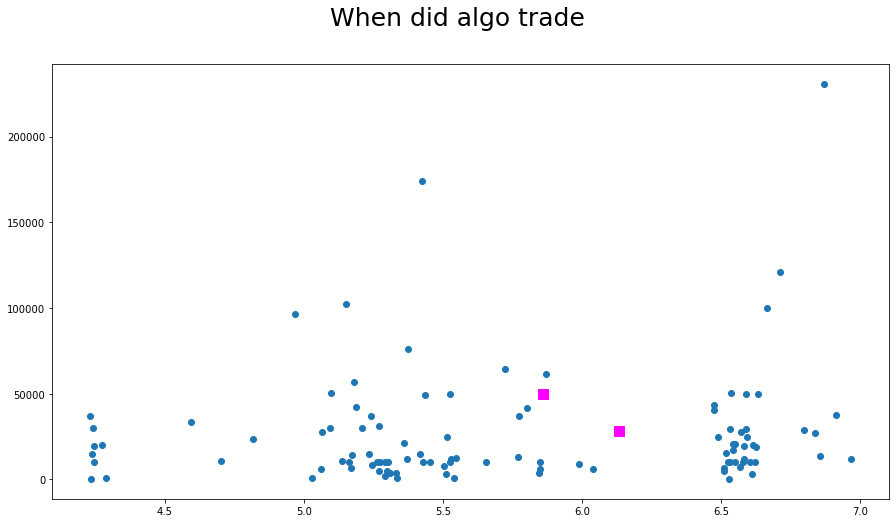

In [212]:
plt.suptitle('When did algo trade', fontsize='25')
plt.scatter(merged_clean_vwap['vwap'], merged_clean_vwap['Executed_Size'])
plt.scatter(merged_clean_vwap['vwap'][merged_clean_vwap.index == '05/05/2020  10:28:44'],merged_clean_vwap['Executed_Size'][merged_clean_vwap.index == '05/05/2020  10:28:44'],  color="fuchsia", marker='s', s = 100)
plt.scatter(merged_clean_vwap['vwap'][merged_clean_vwap.index == '05/05/2020  10:41:33'],merged_clean_vwap['Executed_Size'][merged_clean_vwap.index == '05/05/2020  10:41:33'],  color="fuchsia", marker='s', s = 100)

The VWAPs at that moment resp. were:

In [203]:
merged_clean_vwap[merged_clean_vwap.index == '05/05/2020  10:28:44']

,Executed_Size,Price_of_Execution,Size_at_Bid,Bid,Size_at_Ask,Ask,volume_time,Volume,Cumulative Volume,Spread,vwap
Dates,,,,,,,,,,,
2020-05-05 10:28:44,28353.0,4.2,205919.0,4.195,81547.0,4.2,2020-05-05 10:28:00,252013,688666.0,0.005,6.132606


In [204]:
merged_clean_vwap[merged_clean_vwap.index == '05/05/2020  10:41:33']

,Executed_Size,Price_of_Execution,Size_at_Bid,Bid,Size_at_Ask,Ask,volume_time,Volume,Cumulative Volume,Spread,vwap
Dates,,,,,,,,,,,
2020-05-05 10:41:33,50000.0,4.2,NaN,NaN,353836.0,4.2,2020-05-05 10:41:00,62426,842815.0,NaN,5.85851


Now, let's try running the stumpy procedure again. 

The motif is located at index 65
The nearest neighbor is located at index 55


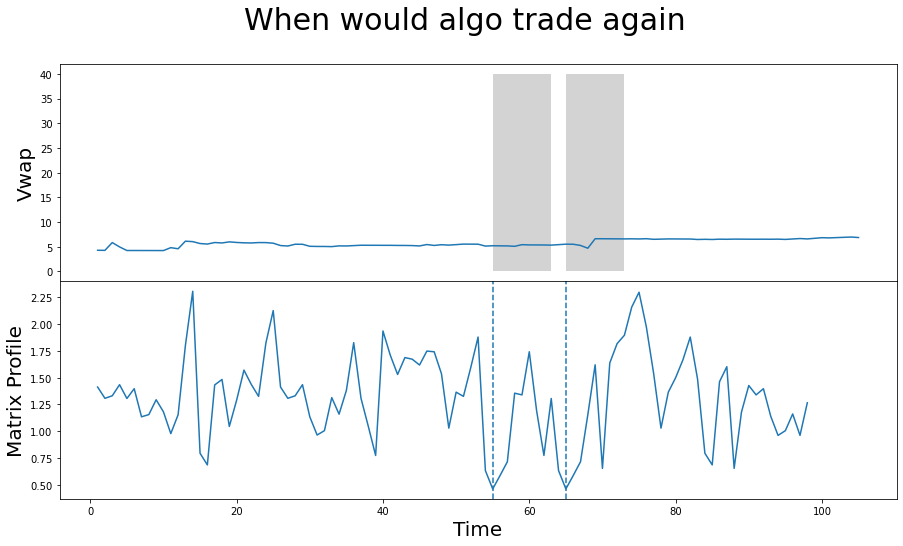

In [209]:
#finding motif via stumpy package for vwap
m = 8
mp = stumpy.stump(merged_clean_vwap['vwap'], m)


motif_idx = np.argsort(mp[:, 0])[0]
print(f"The motif is located at index {motif_idx}")


nearest_neighbor_idx = mp[motif_idx, 1]
print(f"The nearest neighbor is located at index {nearest_neighbor_idx}")

fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('When would algo trade again', fontsize='30')

axs[0].plot(merged_clean_vwap['vwap'].values)
axs[0].set_ylabel('Vwap', fontsize='20')
rect = Rectangle((motif_idx, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((nearest_neighbor_idx, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].axvline(x=motif_idx, linestyle="dashed")
axs[1].axvline(x=nearest_neighbor_idx, linestyle="dashed")
axs[1].plot(mp[:, 0])
plt.show()

In [210]:
merged_clean_vwap[merged_clean_vwap.index == merged_clean_vwap.index[55]]

,Executed_Size,Price_of_Execution,Size_at_Bid,Bid,Size_at_Ask,Ask,volume_time,Volume,Cumulative Volume,Spread,vwap
Dates,,,,,,,,,,,
2020-05-05 12:22:30,29783.0,4.15,20217.0,4.15,26090.0,4.155,2020-05-05 12:22:00,40461,2276651.0,0.005,5.209298


In [208]:
merged_clean_vwap[merged_clean_vwap.index == merged_clean_vwap.index[65]]

,Executed_Size,Price_of_Execution,Size_at_Bid,Bid,Size_at_Ask,Ask,volume_time,Volume,Cumulative Volume,Spread,vwap
Dates,,,,,,,,,,,
2020-05-05 12:42:43,50000.0,4.15,77421.0,4.145,185223.0,4.151667,2020-05-05 12:42:00,64000,2759083.0,0.006667,5.525013


As we can see these blocks are very similar to the ones indicated as executed by the algo but at better VWAPs (5.209 and 5.52 compared to 6.13 and 5.85 earlier). <font size="4"> In the plot marked as green diamonds are the suggested blocks.</font> 

Text(Dates
2020-05-05 12:22:30    5.009298
Name: vwap, dtype: float64, Dates
2020-05-05 12:22:30    39783.0
Name: Executed_Size, dtype: float64, 'Algo trades here')

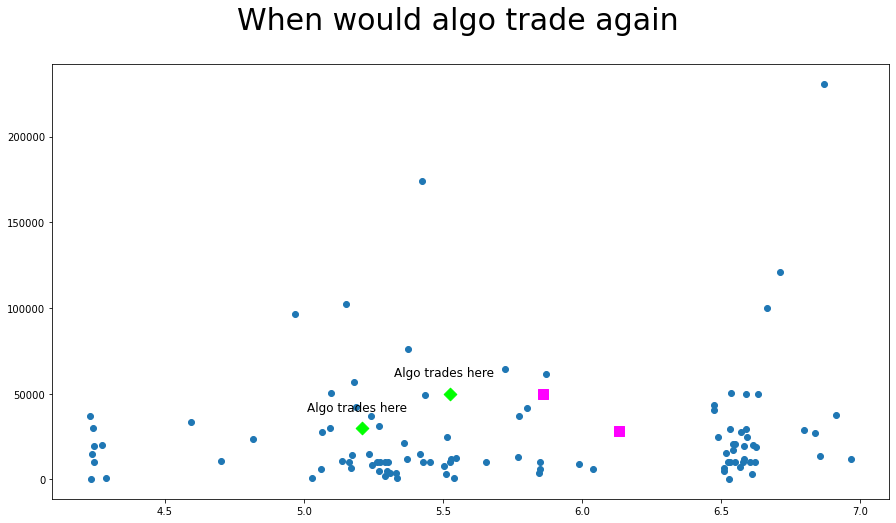

In [211]:
plt.suptitle('When would algo trade again', fontsize='30')
plt.scatter(merged_clean_vwap['vwap'], merged_clean_vwap['Executed_Size'])
plt.scatter(merged_clean_vwap['vwap'][merged_clean_vwap.index == merged_clean_vwap.index[65]],merged_clean_vwap['Executed_Size'][merged_clean_vwap.index == merged_clean_vwap.index[65]],  color="lime", s=80, marker='D')
plt.scatter(merged_clean_vwap['vwap'][merged_clean_vwap.index == merged_clean_vwap.index[55]],merged_clean_vwap['Executed_Size'][merged_clean_vwap.index == merged_clean_vwap.index[55]],  color="lime", s=80, marker='D')
plt.scatter(merged_clean_vwap['vwap'][merged_clean_vwap.index == '05/05/2020  10:28:44'],merged_clean_vwap['Executed_Size'][merged_clean_vwap.index == '05/05/2020  10:28:44'],  color="fuchsia", marker='s', s = 100)
plt.scatter(merged_clean_vwap['vwap'][merged_clean_vwap.index == '05/05/2020  10:41:33'],merged_clean_vwap['Executed_Size'][merged_clean_vwap.index == '05/05/2020  10:41:33'],  color="fuchsia", marker='s', s = 100)
plt.text(merged_clean_vwap['vwap'][merged_clean_vwap.index == merged_clean_vwap.index[65]]-0.2,merged_clean_vwap['Executed_Size'][merged_clean_vwap.index == merged_clean_vwap.index[65]]+10000,"Algo trades here", fontsize=12)
plt.text(merged_clean_vwap['vwap'][merged_clean_vwap.index == merged_clean_vwap.index[55]]-0.2,merged_clean_vwap['Executed_Size'][merged_clean_vwap.index == merged_clean_vwap.index[55]]+10000,"Algo trades here", fontsize=12)